In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from helpers import *
from matplotlib import pyplot as plt
import numpy as np
from experiment_mnist import *
from experiment_constant import *
from experiment_random import *
from scipy.special import expit
import pandas as pd
import seaborn as sns

Using TensorFlow backend.


Initialized TensorFlow


In [2]:
# run with train dropout
#exp = MNISTExperiment([200, 200, 200, 100, 50], [p, 0, 0, 0, 0], 1, epochs = 100, activation = 'relu', reg_type = 0, do_print = True, train_dropout_l1 = p_train)

# run for regular MNIST
# exp = MNISTExperiment([200, 200, 200], [p, 0, 0], 1, epochs = 100, activation = 'relu', reg_type = 0, do_print = True)

# pfail at the first layer
# p = 0.01
#exp = MNISTExperiment([50, 50], [p, 0], 1, epochs = 50, activation = 'sigmoid', reg_type = 0, do_print = True)

### Fixed Random experiment

In [25]:
# pfailure for the first layer
p = 1e-2

In [30]:
# run with random weights and multiple inputs
exp = RandomExperiment([50, 50, 50, 50, 50, 5], [p, 0, 0, 0], 1, activation = 'relu', std_weight = 3, mean_weight = 0.1)

100%|██████████| 50/50 [00:03<00:00, 13.48it/s]


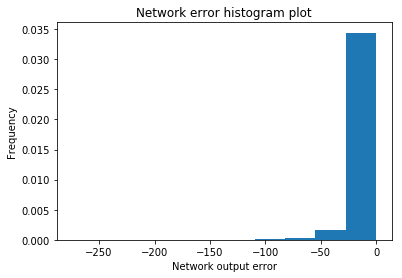

Absolute Error; average over inputs, average over dropout:
True values array mean: 447.158081 std 496.711304
Bound L1Prod  57.721040
Bound L2Prod  10.373345
Bound L1Sum   29.553305
Bound L2Sum   21.826870
Bound FSum    25.341995
Bound v1      10.177679 Std 18.910861
Bound v2      4.810116
Bound v3 app  24.187911
Bound v3 exct 21.746948 Std 31.903805
Bound v3 bttr 21.746929 Std 31.903778
Experiment    22.080376 Std 31.816538
MeanAct [0.502888 0.980704 1.       1.      ]


In [33]:
# inputs to test
data = np.random.randn(50, 50) * 2

# obtaining data
r = exp.run(inputs = data, repetitions = 10000)

Only have v3_approx and v3_exact which support individual input vectors

In [35]:
# looking at output shapes
shapes = [[key, np.array(value).shape] for key, value in r.items()]
pd.DataFrame(shapes, columns = ['name', 'shape'])

,name,shape
0,input,"(50, 50)"
1,activations,"(50, 4)"
2,output,"(50, 5)"
3,error_exp_mean,"(50, 5)"
4,error_exp_std,"(50, 5)"
5,error_abs_exp_mean,"(50, 5)"
6,error_abs_exp_std,"(50, 5)"
7,error_v1_mean,()
8,error_v1_std,()
9,error_v2_mean,"(5,)"


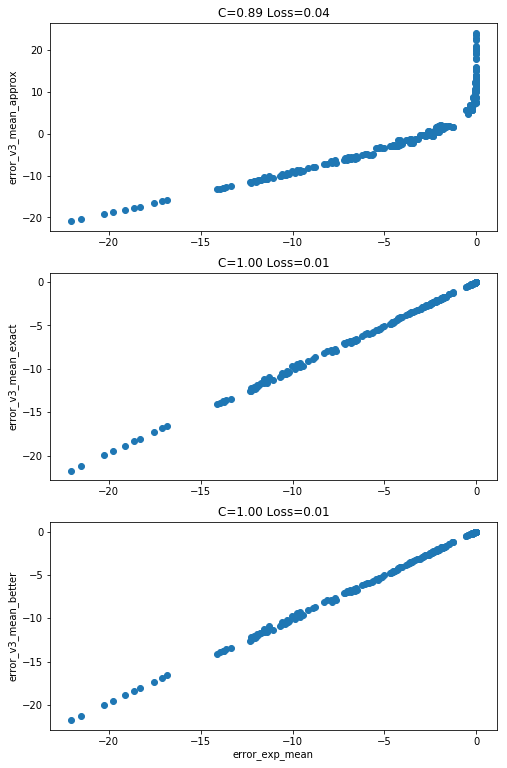

In [67]:
# experimental error
main_key = 'error_exp_mean'

# theoretical bounds
other_keys = ['error_v3_mean_exact', 'error_v3_mean_approx', 'error_v3_mean_better']

# all values
all_keys = [main_key] + other_keys

# dataframe
data = pd.DataFrame({key: r[key].flatten() for key in all_keys})

# correlation
corr = data.corr()[main_key]

# rank loss
loss = {x: min(y, 1 - y) for x, y in compute_rank_losses(data, main_key).items()}

# sorting by corr. coeff
other_keys = sorted(other_keys, key = lambda key: np.abs(corr[key]))

# plotting scatter plots with experimental mean
fig, axs = plt.subplots(3, 1, figsize=(8, 13))
axs = axs.ravel()
for i, key in enumerate(other_keys):
    axs[i].set_title('C=%.2f Loss=%.2f' % (corr[key], loss[key]))
    if i + 1 == len(other_keys):
        axs[i].set_xlabel(main_key)
    axs[i].set_ylabel(key)
    axs[i].scatter(data[main_key], data[key] * np.sign(corr[key]))

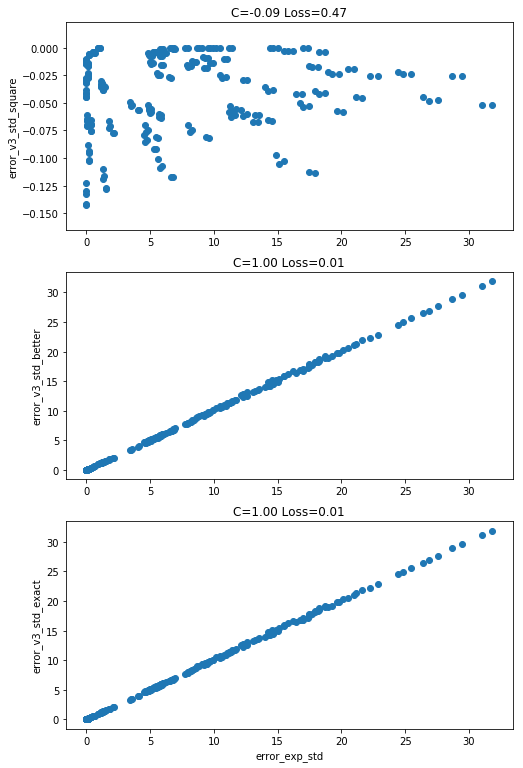

In [68]:
# experimental error
main_key = 'error_exp_std'

# theoretical bounds
other_keys = ['error_v3_std_exact', 'error_v3_std_square', 'error_v3_std_better']

# all values
all_keys = [main_key] + other_keys

# dataframe
data = pd.DataFrame({key: r[key].flatten() for key in all_keys})

# correlation
corr = data.corr()[main_key]

# rank loss
loss = {x: min(y, 1 - y) for x, y in compute_rank_losses(data, main_key).items()}

# sorting by corr. coeff
other_keys = sorted(other_keys, key = lambda key: np.abs(corr[key]))

# plotting scatter plots with experimental mean
fig, axs = plt.subplots(3, 1, figsize=(8, 13))
axs = axs.ravel()
for i, key in enumerate(other_keys):
    axs[i].set_title('C=%.2f Loss=%.2f' % (corr[key], loss[key]))
    if i + 1 == len(other_keys):
        axs[i].set_xlabel(main_key)
    axs[i].set_ylabel(key)
    axs[i].scatter(data[main_key], data[key] * np.sign(corr[key]))

See that there's correlation of approximately 0.999... between theory (v3.exact and v3.better) and practive (experiment, mean over repetitions). Same is not true for the approximate bound which gives somethins about 0.90. Again, exact bound is better in rank loss. Squared version of the variance bound also doesn't work

### Comparing random networks on a fixed input

In [69]:
# pfailure for the first layer
p = 1e-2

# input to test
data = np.random.randn(1, 50) * 2 + 0.1

In [71]:
# array with networks
results = []

# looking at 50 random networks
for i in tqdm(range(100)):
    # run with random weights and multiple inputs
    exp = RandomExperiment([50, 50, 50, 1], [p, 0], 1, activation = 'relu', std_weight = 3, mean_weight = 0.1)

    # obtaining data
    r = exp.run(inputs = data, repetitions = 10000, do_plot = False, do_tqdm = False, do_print = False)
    
    # adding to results
    results += [r]
    
    # removing the model
    K.clear_session()

100%|██████████| 100/100 [01:35<00:00,  1.08it/s]


,value,Correlation,Rank Loss
0,error_v3_mean_better,0.994156,0.032727
1,error_v3_mean_exact,0.994156,0.032727
2,error_v2_mean,-0.989783,0.042626
3,error_matnorm_prod_l2,-0.892769,0.148485
4,error_matnorm_prod_l1,-0.811797,0.171717
5,error_v3_mean_approx,0.720909,0.215960
6,error_v1_mean,-0.617618,0.287677
7,error_matnorm_sum_F,-0.321157,0.397980
8,error_matnorm_sum_l2,-0.319104,0.400606
9,error_matnorm_sum_l1,-0.265832,0.428687


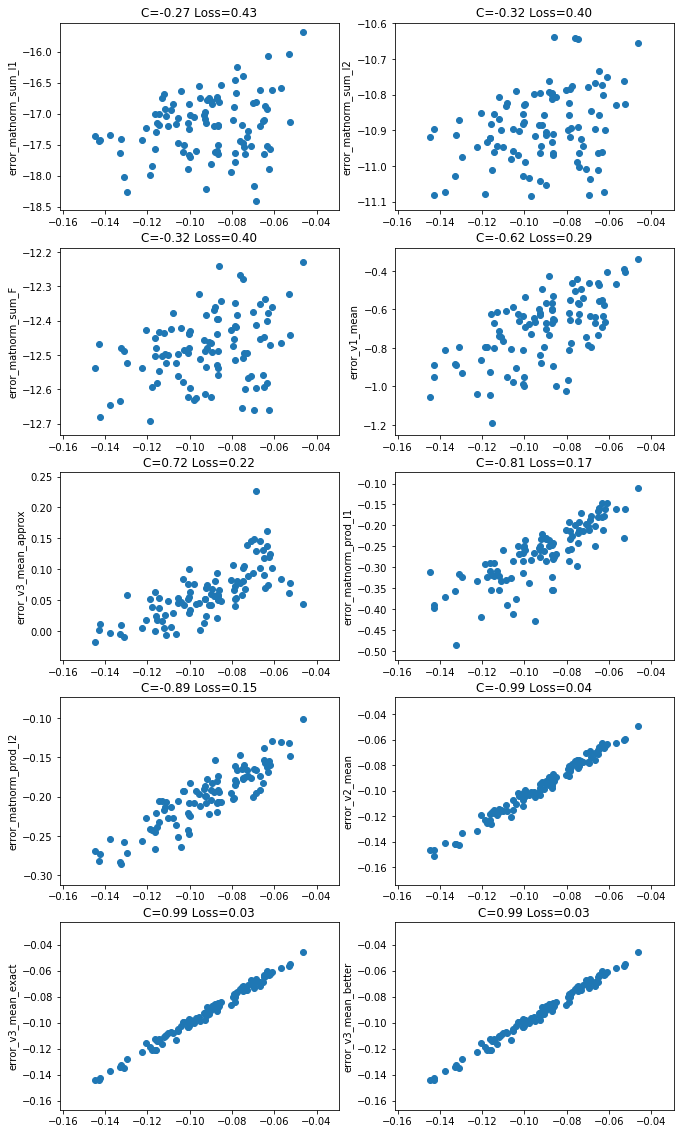

In [114]:
# creating a dataframe with mean bounds
data = {}

# loop over networks
for net in results:
    for key, value in net.items():
        if key not in data: data[key] = []
        data[key] += [np.mean(value)]

# removing extra columns
del data['input']
del data['error_abs_exp_mean']
del data['output']
del data['activations']

# removing columns on variance
for col in list(data.keys()):
    if col.find('std') >= 0:
        del data[col]

# converting to df
data = pd.DataFrame(data)

# plotting scatter plots with experimental mean
main_key = 'error_exp_mean'

# correlation
corr = data.corr()[main_key]

# rank loss
loss = {x: min(y, 1 - y) for x, y in compute_rank_losses(data, main_key).items()}

# sorting keys by abs. correlation
other_keys = [key for key in data.keys() if key != main_key]
other_keys = sorted(other_keys, key = lambda key: np.abs(corr[key]))

# plotting
fig, axs = plt.subplots(5, 2, figsize=(11, 20))
axs = axs.ravel()
for i, key in enumerate(other_keys):
    axs[i].set_title('C=%.2f Loss=%.2f' % (corr[key], loss[key]))
    #axs[i].set_xlabel(main_key)
    axs[i].set_ylabel(key)
    axs[i].scatter(data[main_key], data[key] * np.sign(corr[key]))

# List the best bounds
pd.DataFrame([(key, corr[key], loss[key]) for key in other_keys[::-1]], columns = ['value', 'Correlation', 'Rank Loss'])

,value,Correlation,Rank Loss
0,error_v3_std_exact,0.995479,0.032323
1,error_v3_std_better,0.995479,0.032323
2,error_v3_std_square,0.977176,0.066263
3,error_matnorm_prod_l2,0.959551,0.093131
4,error_v1_std,0.780125,0.213737
5,error_matnorm_prod_l1,0.734962,0.203636
6,error_matnorm_sum_l2,0.364339,0.390909
7,error_matnorm_sum_F,0.354289,0.393131
8,error_matnorm_sum_l1,0.342417,0.420202


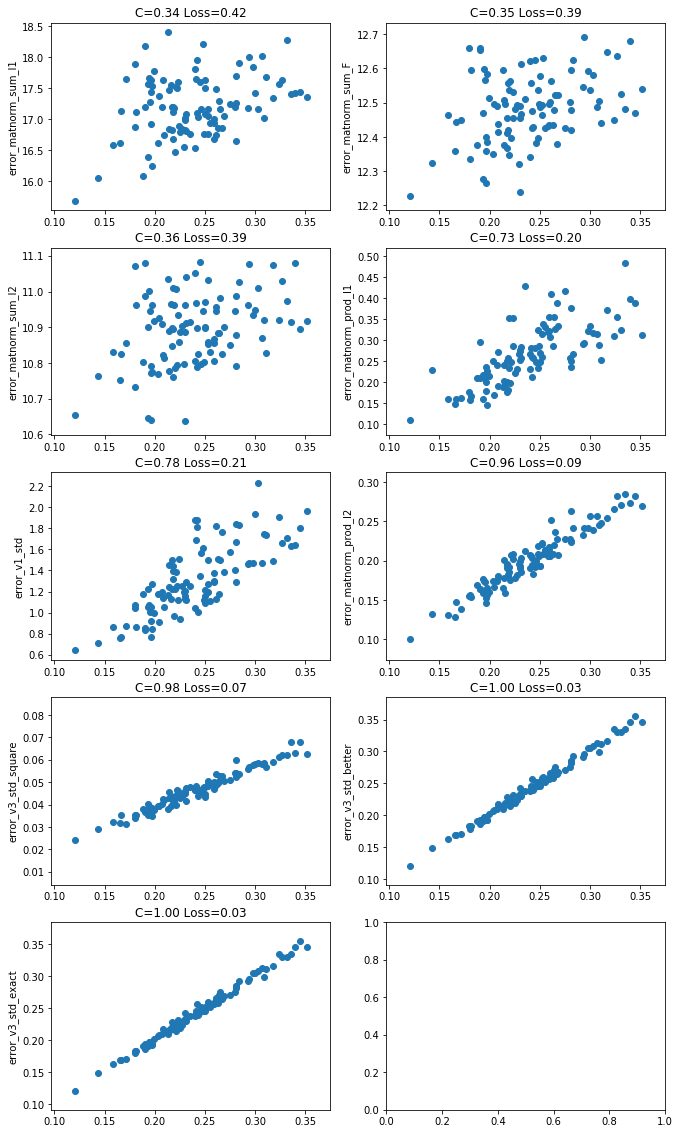

In [117]:
# creating a dataframe with mean bounds
data = {}

# loop over networks
for net in results:
    for key, value in net.items():
        if key not in data: data[key] = []
        data[key] += [np.mean(value)]

# removing extra columns
del data['input']
del data['error_abs_exp_std']
del data['output']
del data['activations']

# removing columns on variance
for col in list(data.keys()):
    if col.find('mean') >= 0:
        del data[col]

# converting to df
data = pd.DataFrame(data)

# plotting scatter plots with experimental mean
main_key = 'error_exp_std'

# correlation
corr = data.corr()[main_key]

# rank loss
loss = {x: min(y, 1 - y) for x, y in compute_rank_losses(data, main_key).items()}

# sorting keys by abs. correlation
other_keys = [key for key in data.keys() if key != main_key]
other_keys = sorted(other_keys, key = lambda key: np.abs(corr[key]))

# plotting
fig, axs = plt.subplots(5, 2, figsize=(11, 20))
axs = axs.ravel()
for i, key in enumerate(other_keys):
    axs[i].set_title('C=%.2f Loss=%.2f' % (corr[key], loss[key]))
    #axs[i].set_xlabel(main_key)
    axs[i].set_ylabel(key)
    axs[i].scatter(data[main_key], data[key] * np.sign(corr[key]))

# List the best bounds
pd.DataFrame([(key, corr[key], loss[key]) for key in other_keys[::-1]], columns = ['value', 'Correlation', 'Rank Loss'])